In [15]:
import random
import pickle
import numpy as np
import tqdm.auto as tqdm

from torch.nn.modules.loss import _WeightedLoss
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
# import torch.tensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import torchvision.models as models

from scipy.spatial import distance
from medpy import metric
from collections import Counter

In [14]:
!pip install medpy

 ### Set the device: cpu or gpu

In [16]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cpu


### Load the data

In [18]:
with open('/Users/pabharathi/Documents/GOES/Data/Data/train_data_scaled.pkl','rb') as f:
    x = pickle.load(f)

In [19]:
print("Saved shape:", x.shape)
x = x.transpose(0,3,1,2)
print("Reshaped to:", x.shape)

Saved shape: (151246, 32, 32, 4)
Reshaped to: (151246, 4, 32, 32)


In [20]:
num_channels = len(x [0,:, 0, 0])

In [23]:
with open('/Users/pabharathi/Documents/GOES/Data/Data/train_counts.pkl','rb') as f:
    y = pickle.load(f)

In [9]:
#Find the channel-wise mean for the images that are classified as zero
#Create a baseline zero tensor using the channel-wise averages
#Later used as a potential baseline for Integrated Gradients and Deeplift
tensor = torch.tensor((), dtype=torch.float)
base_zero= torch.zeros([num_channels, 32, 32])
zero_idx = np.argwhere(y.squeeze() == 0).squeeze()
for i in range(0, num_channels):
    currchannel_mean = np.mean(x[zero_idx, i, :, :].flatten())
    base_zero[i] = tensor.new_full((32, 32), currchannel_mean)

In [24]:
print("Saved shape:", y.shape)
y = y.reshape(y.shape[0], 1)
print("Reshaped to:", y.shape)

Saved shape: (151246,)
Reshaped to: (151246, 1)


### Subsample the data 

In [ ]:
# gt0 = list(np.where(y >= 1)[0])
# lt0 = list(np.where(y < 1)[0])
# take_a_sample = random.sample(lt0, 10)

# sample = gt0 + take_a_sample

# x = x[sample]
# y = y[sample]



### Split the data into train / test partitions (80 / 20 split)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.2, random_state = 5000
)

##### Create a histogram of the (log) counts

<ipython-input-26-e2a65150e9f1>:1: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.log(Y_train),bins=range(200))


(0.0, 50.0)

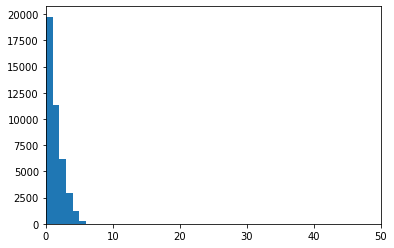

In [26]:
plt.hist(np.log(Y_train),bins=range(200))
plt.xlim([0,50])

##### Create labels for binned lightning counts 

In [27]:
bins = [10, 100]

y_train = np.where(Y_train[:] > 0.0, 1, 0)
y_test = np.where(Y_test[:] > 0.0, 1, 0)

for p,q in enumerate(bins):
    y_train = np.where(Y_train[:] >= q, p+2, y_train)
    y_test = np.where(Y_test[:] >= q, p+2, y_test)

In [28]:
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)
X_IG = X_test
Y_IG = y_test

(120996, 1)
(30250, 1)
(120996, 4, 32, 32)
(30250, 4, 32, 32)


In [82]:
#Initialize random choice seed
rng = np.random.default_rng(2021)
print(rng.choice(range(1,1000)))
print(rng.choice(range(1,1000)))

757
757


In [80]:
rng.choice(range(1,1000))

889

In [29]:
#Sample thirty of each of the classes for use in Integrated Gradients
#First get all the indices for each class then sample twenty images from each
#Comment out classes that do not exist in the current iteration
rng = np.random.default_rng(2021)
test_classsize = 30

zero_idx = np.argwhere(y_test.squeeze() == 0).squeeze()
zero_randomidx = rng.choice(zero_idx, size=test_classsize, replace=False )

one_idx = np.argwhere(y_test.squeeze() == 1).squeeze()
one_randomidx = rng.choice(one_idx, size=test_classsize, replace=False )

two_idx = np.argwhere(y_test.squeeze() == 2).squeeze()
two_randomidx = rng.choice(two_idx, size=test_classsize, replace=False )

three_idx = np.argwhere(y_test.squeeze() == 3).squeeze()
three_randomidx = rng.choice(three_idx, size=test_classsize, replace=False )

test_randomidx = np.concatenate((zero_randomidx, one_randomidx, two_randomidx, three_randomidx))
print(two_randomidx)

[ 3903 16877  2407  4118 22377  9373 17785  2915  6057 28475  8074 27545
  2329  6658 10846 18680 15150  3791 22171 21571  1280  4897 27084 26222
 23647  6867 18487  8406  7772 15967]


### Create class weights based on counts 

In [30]:
counts = Counter()
for val in y_train:
    counts[val[0]] += 1
counts = dict(counts)


#weights = [1 - (counts[x] / sum(counts.values())) for x in sorted(counts.keys())]
weights = [np.log1p(max(counts.values()) / counts[x]) for x in sorted(counts.keys())]
weights = [x / max(weights) for x in weights]
weights = torch.FloatTensor(weights).to(device)

print(weights)

tensor([0.1438, 0.2546, 0.4937, 1.0000])


## Load a Model 

In [31]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv1d(4, 64, (7, 7), (2, 2), (3, 3), bias=False)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [32]:
output_size = len(weights) 
fcl_layers = []
dropout = 0.5

model = ResNet(fcl_layers, dr = dropout, output_size = output_size, resnet_model=18, pretrained = False).to(device)

### Test model to make sure the architecture is consistent on a batch size of 2


In [33]:
X = torch.from_numpy(X_train[:2]).float().to(device)
print(X.shape)
g = model(X).exp()
#print(torch.max(g,1)) # exp to turn the logits into probabilities, since we used LogSoftmax
print(g)
#print(torch.argmax(g,1))

torch.Size([2, 4, 32, 32])
tensor([[0.2713, 0.1060, 0.5239, 0.0989],
        [0.3005, 0.0731, 0.5396, 0.0868]], grad_fn=<ExpBackward>)


/Users/pabharathi/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Load Optimizers

In [34]:
learning_rate = 1e-03
weight_decay = 1e-09
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Load Custom Loss Function
THe modified loss function comes with label smoothing

In [35]:
class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    def k_one_hot(self, targets:torch.Tensor, n_classes:int, smoothing=0.0):
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes),
                                  device=targets.device) \
                                  .fill_(smoothing /(n_classes-1)) \
                                  .scatter_(1, targets.data.unsqueeze(1), 1.-smoothing)
        return targets

    def reduce_loss(self, loss):
        return loss.mean() if self.reduction == 'mean' else loss.sum() \
        if self.reduction == 'sum' else loss

    def forward(self, inputs, targets):
        assert 0 <= self.smoothing < 1

        targets = self.k_one_hot(targets, inputs.size(-1), self.smoothing)
        log_preds = F.log_softmax(inputs, -1)

        if self.weight is not None:
            log_preds = log_preds * self.weight.unsqueeze(0)

        return self.reduce_loss(-(targets * log_preds).sum(dim=-1))

In [36]:
train_criterion = SmoothCrossEntropyLoss(weight = weights) #weight = weights, smoothing = 0.1) 
test_criterion = torch.nn.CrossEntropyLoss()  

## Set up Top-K Accuracy Calculations

In [37]:
def torch_accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-5 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        # ---- get the topk most likely labels according to your model
        # get the largest k \in [n_classes] (i.e. the number of most likely probabilities we will use)
        maxk = max(topk)  # max number labels we will consider in the right choices for out model
        batch_size = target.size(0)

        # get top maxk indicies that correspond to the most likely probability scores
        # (note _ means we don't care about the actual top maxk scores just their corresponding indicies/labels)
        _, y_pred = output.topk(k=maxk, dim=1)  # _, [B, n_classes] -> [B, maxk]
        y_pred = y_pred.t()  # [B, maxk] -> [maxk, B] Expects input to be <= 2-D tensor and transposes dimensions 0 and 1.

        # - get the credit for each example if the models predictions is in maxk values (main crux of code)
        # for any example, the model will get credit if it's prediction matches the ground truth
        # for each example we compare if the model's best prediction matches the truth. If yes we get an entry of 1.
        # if the k'th top answer of the model matches the truth we get 1.
        # Note: this for any example in batch we can only ever get 1 match (so we never overestimate accuracy <1)
        target_reshaped = target.view(1, -1).expand_as(y_pred)  # [B] -> [B, 1] -> [maxk, B]
        # compare every topk's model prediction with the ground truth & give credit if any matches the ground truth
        correct = (y_pred == target_reshaped)  # [maxk, B] were for each example we know which topk prediction matched truth
        # original: correct = pred.eq(target.view(1, -1).expand_as(pred))

        # -- get topk accuracy
        list_topk_accs = []  # idx is topk1, topk2, ... etc
        for k in topk:
            # get tensor of which topk answer was right
            ind_which_topk_matched_truth = correct[:k]  # [maxk, B] -> [k, B]
            # flatten it to help compute if we got it correct for each example in batch
            flattened_indicator_which_topk_matched_truth = ind_which_topk_matched_truth.reshape(-1).float()  # [k, B] -> [kB]
            # get if we got it right for any of our top k prediction for each example in batch
            tot_correct_topk = flattened_indicator_which_topk_matched_truth.float().sum(dim=0, keepdim=True)  # [kB] -> [1]
            # compute topk accuracy - the accuracy of the mode's ability to get it right within it's top k guesses/preds
            topk_acc = tot_correct_topk / batch_size  # topk accuracy for entire batch
            list_topk_accs.append(topk_acc.item())
        return list_topk_accs 

## Train the Model

In [38]:
# this will help lower the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(
    optimizer, 
    patience = 10, 
    min_lr = 1.0e-10,
    verbose = True
)

In [39]:
epochs = 300
train_batch_size = 5
valid_batch_size = 128
batches_per_epoch = 500

topk = (1, 2)
patience = 50

### Data Iterators for Model Loading

In [40]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=train_batch_size, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=valid_batch_size,
    shuffle=False)

In [43]:
epoch_test_losses = []

for epoch in range(epochs):

    ### Train the model 
    model.train()

    # Shuffle the data first
    batch_loss = []
    accuracy = {k: [] for k in topk}
    indices = list(range(X_train.shape[0]))
    random.shuffle(indices)
    
    # Now split into batches
    train_batches_per_epoch = int(X_train.shape[0] / train_batch_size) 
    train_batches_per_epoch = min(batches_per_epoch, train_batches_per_epoch)
    
    # custom tqdm so we can see the progress
    batch_group_generator = tqdm.tqdm(
        enumerate(train_loader), 
        total=train_batches_per_epoch, 
        leave=True
    )

    for k, (x, y) in batch_group_generator:

        # Converting to torch tensors and moving to GPU
        inputs = x.float().to(device)
        lightning_counts = y.long().to(device)

        # Clear gradient
        optimizer.zero_grad()

        # get output from the model, given the inputs
        pred_lightning_counts = model(inputs)

        # get loss for the predicted output
        loss = train_criterion(pred_lightning_counts, lightning_counts.squeeze(-1))
        
        # compute the top-k accuracy
        acc = torch_accuracy(pred_lightning_counts.cpu(), lightning_counts.cpu(), topk = topk)
        for i,l in enumerate(topk):
            accuracy[l] += [acc[i]]

        # get gradients w.r.t to parameters
        loss.backward()
        batch_loss.append(loss.item())

        # update parameters
        optimizer.step()

        # update tqdm
        to_print = "Epoch {} train_loss: {:.4f}".format(epoch, np.mean(batch_loss))
        for l in sorted(accuracy.keys()):
            to_print += " top-{}_acc: {:.4f}".format(l,np.mean(accuracy[l]))
        #to_print += " top-2_acc: {:.4f}".format(np.mean(accuracy[2])
        #to_print += " top-3_acc: {:.4f}".format(np.mean(accuracy[3]))
        to_print += " lr: {:.12f}".format(optimizer.param_groups[0]['lr'])
        batch_group_generator.set_description(to_print)
        batch_group_generator.update()
                                  
        if k >= train_batches_per_epoch and k > 0:
            break
        
    torch.cuda.empty_cache()

    ### Test the model 
    model.eval()
    with torch.no_grad():

        batch_loss = []
        accuracy = {k: [] for k in topk}
        
        # custom tqdm so we can see the progress
        valid_batches_per_epoch = int(X_test.shape[0] / valid_batch_size) 
        batch_group_generator = tqdm.tqdm(
            test_loader, 
            total=valid_batches_per_epoch, 
            leave=True
        )

        for (x, y) in batch_group_generator:
            # Converting to torch tensors and moving to GPU
            inputs = x.float().to(device)
            lightning_counts = y.long().to(device)
            # get output from the model, given the inputs
            pred_lightning_counts = model(inputs)
            # get loss for the predicted output
            loss = test_criterion(pred_lightning_counts, lightning_counts.squeeze(-1))
            batch_loss.append(loss.item())
            # compute the accuracy
            acc = torch_accuracy(pred_lightning_counts, lightning_counts, topk = topk)
            for i,k in enumerate(topk):
                accuracy[k] += [acc[i]]
            # update tqdm
            to_print = "Epoch {} test_loss: {:.4f}".format(epoch, np.mean(batch_loss))
            for k in sorted(accuracy.keys()):
                to_print += " top-{}_acc: {:.4f}".format(k,np.mean(accuracy[k]))
            batch_group_generator.set_description(to_print)
            batch_group_generator.update()

    test_loss = 1 - np.mean(accuracy[1])
    epoch_test_losses.append(test_loss)
    
    # Lower the learning rate if we are not improving
    lr_scheduler.step(test_loss)

    # Save the model if its the best so far.
    if test_loss == min(epoch_test_losses):
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss
        }
        torch.save(state_dict, "best.pt")
        
    # Stop training if we have not improved after X epochs
    best_epoch = [i for i,j in enumerate(epoch_test_losses) if j == min(epoch_test_losses)][-1]
    offset = epoch - best_epoch
    if offset >= patience:
        break

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    37: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    48: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    59: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    81: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    92: reducing learning rate of group 0 to 1.0000e-08.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

##### Load the best model

In [41]:
checkpoint = torch.load(
    "best.pt",
    map_location=lambda storage, loc: storage
)
best_epoch = checkpoint["epoch"]
#model = Net(filter_sizes, fcl_layers).to(device)
model = ResNet(fcl_layers, dr = dropout, output_size = output_size).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/pabharathi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


<All keys matched successfully>

##### Predict on the test dataset with the best model

In [42]:
topk = (1,2)

model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    batch_loss = []
    accuracy = {k: [] for k in topk}
    # split test data into batches

    valid_batches_per_epoch = int(X_test.shape[0] / valid_batch_size) 
    batch_group_generator = tqdm.tqdm(
        test_loader, 
        total=valid_batches_per_epoch, 
        leave=True
    )
    
    for (x, y) in batch_group_generator:
        # Converting to torch tensors and moving to GPU
        inputs = x.float().to(device)
        lightning_counts = y.long().to(device)
        # get output from the model, given the inputs
        pred_lightning_counts = model(inputs)
        # get loss for the predicted output
        loss = test_criterion(pred_lightning_counts, lightning_counts.squeeze(-1))
        batch_loss.append(loss.item())
        # compute the accuracy
        acc = torch_accuracy(pred_lightning_counts, lightning_counts, topk = topk)
        for i,k in enumerate(topk):
            accuracy[k] += [acc[i]]
        
        y_true.append(lightning_counts.squeeze(-1))
        # Taking the top-1 answer here, but here is where we could compute the average predicted rather than take top-1
        y_pred.append(torch.argmax(pred_lightning_counts, 1))

y_true = torch.cat(y_true, axis = 0)
y_pred = torch.cat(y_pred, axis = 0)

In [43]:
y_true = y_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()

In [44]:
print("val_loss", np.mean(batch_loss))
for k in topk:
    print(f"top-{k} {np.mean(accuracy[k])}")

val_loss 0.4334316381925269
top-1 0.8446211950688423
top-2 0.9698660713207873


In [45]:
metrics.accuracy_score(y_true,y_pred,normalize=True)

0.8449917355371901

### Compute accuracy on all labels

In [46]:
for label in list(set(y_true)):
    c = (y_true == label)
    print(label, (y_true[c] == y_pred[c]).mean())

0 0.9281560212573949
1 0.8656184743888957
2 0.0004938271604938272
3 0.0


In [50]:
list(set(y_pred))

[0, 1, 2]

### Plot the confusion matrix 

In [50]:
import seaborn as sn
import pandas as pd

In [55]:
!pip install captum

     |████████████████████████████████| 1.4 MB 1.7 MB/s eta 0:00:01


In [51]:
cm = metrics.confusion_matrix(y_true, y_pred, normalize = 'true')

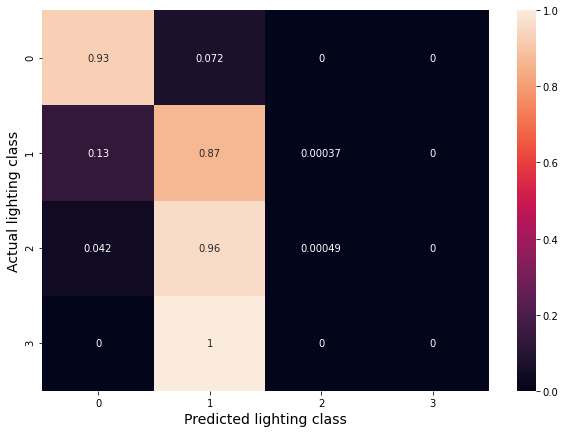

In [53]:
df_cm = pd.DataFrame(cm, index = sorted(list(set(y_true))), columns = sorted(list(set(y_true))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.ylabel("Actual lighting class", fontsize = 14)
plt.xlabel("Predicted lighting class", fontsize = 14)
plt.savefig('13BinConfusion.png')

## Integrated Gradients

In [56]:
import PIL
from PIL import Image


import torchvision
from torchvision import models
from torchvision import transforms

from matplotlib.colors import LinearSegmentedColormap

import captum.attr

from captum.attr import IntegratedGradients
# from captum.attr import GradientShap
# from captum.attr import Occlusion
# from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [57]:
lst_inputs = []
all_images = X_IG[test_randomidx, :, :, :]
print(all_images.shape)


(120, 4, 32, 32)


In [86]:
print(test_randomidx)

[ 4573 15027 18877 27481 14653 16163 18262  8223 17565  1080 28663  8285
  9743  7702 22811 15794 22830 29404 20037  1801  2613 17879 22796  1503
 21785  6603 28143 28468  9752  9224 10717 18110 12093 20870 28289 24898
 15930  8282   628  7653  4261  3326  2511 13681 23678 13892 26705 25589
 12320  9982 14753 14144 28189 21769 18537   748 13665 18371 25672  9802
  3903 16877  2407  4118 22377  9373 17785  2915  6057 28475  8074 27545
  2329  6658 10846 18680 15150  3791 22171 21571  1280  4897 27084 26222
 23647  6867 18487  8406  7772 15967  9941 19935 22658 29505 26237 24640
  2922 19065 10531 19228 23065  3573 18970  1650 19165 19753 10507 11668
 27979 20486   883  8454  8508 23600  7530 18901  1860 15368 16317 12829]


In [59]:
#Compute the model output for all the inputs in the input list
from collections import defaultdict
predicted_dict = defaultdict(list)
total_outputs = []
for idx, input1 in enumerate(all_images):
    input1 = torch.tensor(input1)
    input1= input1.unsqueeze(0)
    output = model(input1)
    output = F.softmax(output, dim =1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    predicted_dict[pred_label_idx.item()].append(idx)
    total_outputs.append(output)

In [61]:
len(predicted_dict)

2

In [62]:
#Initialize the integrated gradients model and run it for each of the inputs
# with respect to each of the picture's predicted class (target is set to label of predicted class)
integrated_gradients = IntegratedGradients(model)
attributions_mult = []
for idx, input1 in enumerate(all_images):
    input1 = torch.tensor(input1)
    input1 = input1.unsqueeze(0)
    prediction_score, pred_label_idx = torch.topk(total_outputs[idx], 1)
    attributions_ig = integrated_gradients.attribute(input1, target = pred_label_idx, n_steps= 50)
    attributions_mult.append(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)))
attributions_mult = np.array(attributions_mult)

In [63]:
#Make sure that the shape of the attributions alligns with that of the transposed images
# We needed to tranpose because visualization packages require channels to be the last dim
print(attributions_mult.shape, np.transpose(all_images, (0, 2, 3, 1)).shape)

(120, 32, 32, 4) (120, 32, 32, 4)


### Various plots depicting attributions against various parameters

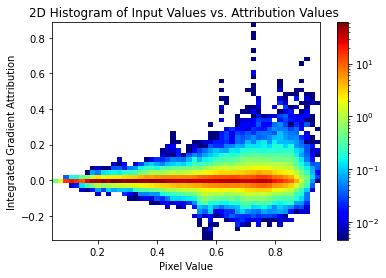

In [91]:
#Create a 2D histogram of the pixel values against the attributions for the attributions

import matplotlib.cm, matplotlib.colors
samp_all= np.transpose(all_images, (0, 2, 3, 1))
plt.xlabel("Pixel Value")
plt.ylabel("Integrated Gradient Attribution")
plt.title("2D Histogram of Input Values vs. Attribution Values ")
hi_ = plt.hist2d(samp_all.flatten(), attributions_mult.flatten(), density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.savefig("inputAttributions_igeven.png")
plt.show()


In [93]:
## 2-d Histograms showing how input values as well as attributions vary acrosss true bins
def attr_classviz(attributions, predictions = None, size = 4, Share = True, Pred = False, y_label = "Integrated Gradient"):
    h,w= 18,12
    if(size == 2):
        m,n = 2,1
        h,w = 9, 12
    if(size == 3):
        m,n = 3,1
        h, w = 6,18
    if(size == 4):
        m,n = 2,2
        h,w = 18, 12
        
    fig, axs = plt.subplots(m, n, figsize = (h, w), sharey = Share)
    classifications = ['No Lightning', '1-10 Lightning', '10-100 Lightning', '100+ Lightning']

    it = 0
    
    if(n == 1):
        for j in range (m):
            axs[j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
            axs[j].set_xlabel("Pixel Value")
            axs[j].set_ylabel(y_label)
            if(Pred==False):
                hi_ = axs[j].hist2d(samp_all[test_classsize*(it):test_classsize+test_classsize*(it), :, :, :].flatten(), 
                              attributions[test_classsize *(it):test_classsize+test_classsize*(it), :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
            else:
                hi_ = axs[j].hist2d(samp_all[predictions[it], :, :, :].flatten(), 
                              attributions[predictions[it], :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
            ax = axs[j]
            fig.colorbar(hi_[3], ax = ax)
            it += 1
    else:
        
        for i in range(m):
            for j in range (n):
                axs[i, j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
                axs[i,j].set_xlabel("Pixel Value")
                axs[i,j].set_ylabel(y_label)
                if(Pred==False):
                    hi_ = axs[i,j].hist2d(samp_all[test_classsize*(it):test_classsize+test_classsize*(it), :, :, :].flatten(), 
                              attributions[test_classsize *(it):test_classsize+test_classsize*(it), :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
                else:
                    hi_ = axs[i,j].hist2d(samp_all[predictions[it], :, :, :].flatten(), 
                              attributions[predictions[it], :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
                ax = axs[i,j]
                fig.colorbar(hi_[3], ax = ax)
                it += 1

    plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)
    return plt

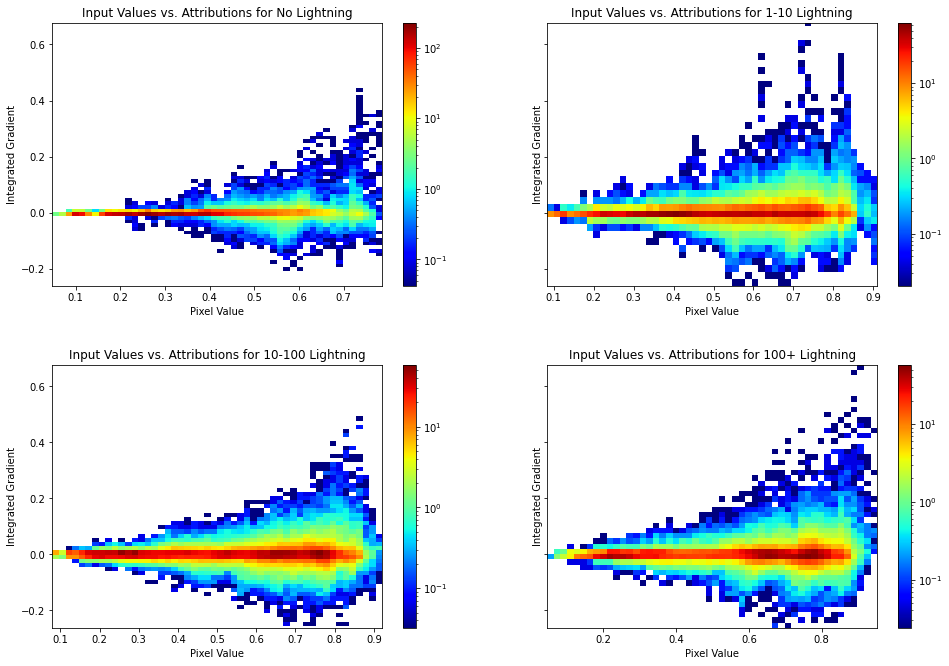

In [94]:
## 2-d Histograms showing how input values as well as attributions vary acrosss true bins
_ = attr_classviz(attributions = attributions_mult)
# fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
# classifications = ['0 Lightning', '1-10 Lightning', '10-100 Lightning', '100+ Lightning']

# it = 0
# for i in range(2):
#     for j in range (2):
#         axs[i, j].set_title("Input Values vs. Attributions for " +
#                             classifications[it])
#         axs[i,j].set_xlabel("Pixel Value")
#         axs[i,j].set_ylabel("Integrated Gradient Attributions")
#         hi_ = axs[i,j].hist2d(samp_all[random_size*(it):random_size+random_size*(it), :, :, :].flatten(), 
#                               attributions_mult[random_size *(it):random_size+random_size*(it), :, :, :].flatten(),
#                               density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
#         ax = axs[i,j]
#         fig.colorbar(hi_[3], ax = ax)
#         it += 1

# plt.subplots_adjust(left=0.2,
#                     bottom=0.2, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
#                     hspace=0.3)

# plt.show()

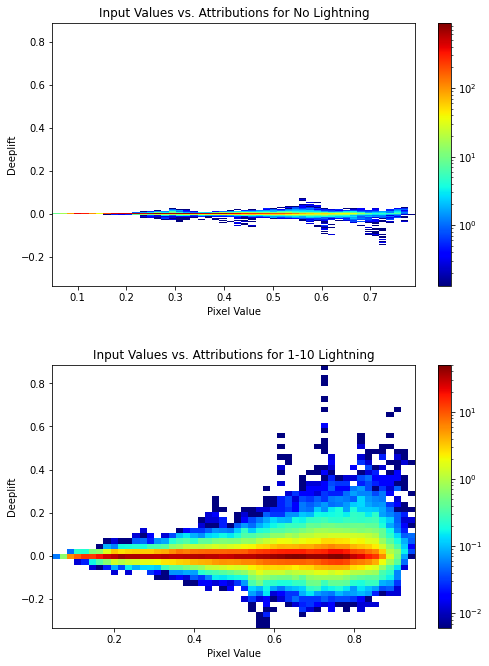

In [95]:
_ = attr_classviz(attributions = attributions_mult, predictions = predicted_dict, size = len(predicted_dict), Pred=True,y_label = "Deeplift")

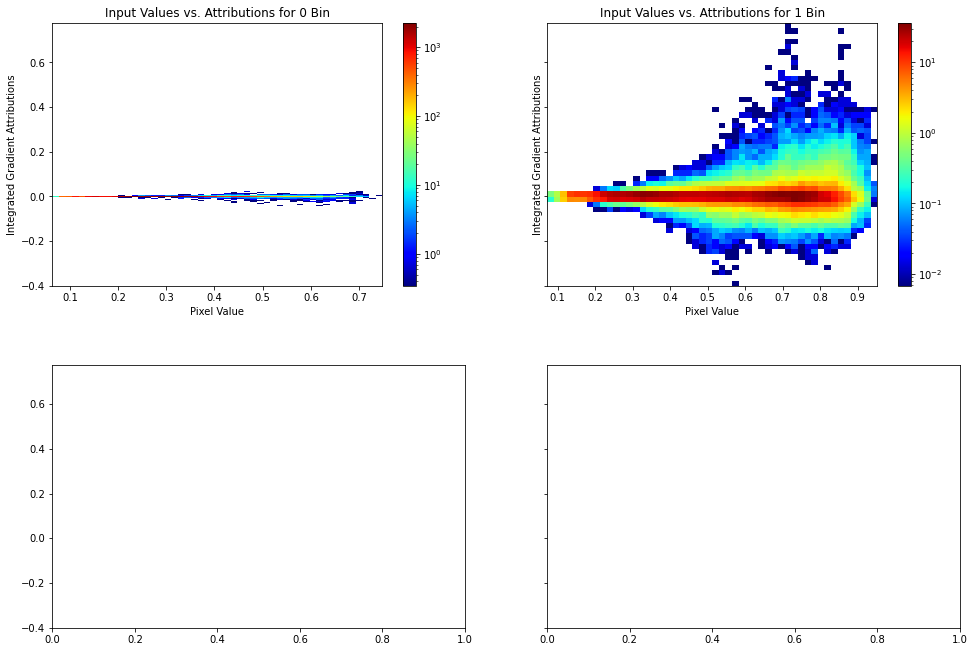

In [45]:
## 2-d Histograms showing how input values as well as attributions vary acrosss predicted bins
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
classifications = ['0 Bin', '1 Bin', '2 Bin', '3 Bin']

it = 0
for i in range(2):
    for j in range (2):
        if(it == len(predicted_dict)):
           break
        axs[i, j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attributions")
        hi_ = axs[i,j].hist2d(samp_all[predicted_dict[it], :, :, :].flatten(), 
                              attributions_mult[predicted_dict[it], :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1
    else:
        continue
    break
    

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

plt.show()

#### An example of standard Integrated Gradients from a bin 3 image ()

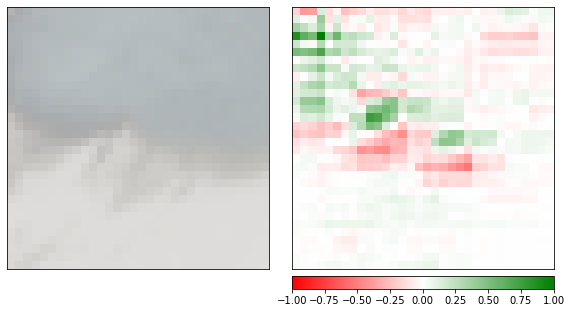

In [76]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(attributions_mult[88,:,:, :],
                                          samp_all[88,:, :, :],
                                          ["original_image", "heat_map"],
                                          ["all", "all"],
                                          show_colorbar=True,
                                            outlier_perc=1)


In [47]:
print(samp_all[k, :, :, i:i+1].shape, attributions_mult[k,:,:, i:i+1].shape)

(32, 32, 1) (32, 32, 1)


In [96]:
def attributions_visualization (attributions, image, cmap=None, curr_class=""):
    fig, axs = plt.subplots(nrows=4, ncols=2, squeeze=False, figsize=(16, 16))
#     fig.subplots_adjust(wspace=0.01)
    
    axs[0, 0].set_title('Band 8 Image')
    _ = axs[0, 0].imshow(image[:, :, 0], vmin = 0, vmax = 1)
    fig.colorbar(_, ax = axs[0, 0])
    axs[0, 0].axis('off')

    
    axs[0, 1].set_title('Band 8 Attributions')
    _ =axs[0, 1].imshow(attributions[:, :, 0],cmap=plt.cm.PuOr, vmin = -0.3, vmax = 0.3)
    fig.colorbar(_, ax = axs[0, 1])
    axs[0, 1].axis('off')

    
    axs[1, 0].set_title('Band 9 Image')
    _ = axs[1, 0].imshow(image[:, :, 1], vmin = 0, vmax = 1)
    fig.colorbar(_, ax = axs[1, 0])
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Band 9 Attributions')
    _ = axs[1, 1].imshow(attributions[:, :, 1],cmap=plt.cm.PuOr, vmin = -0.3, vmax = 0.3)
    fig.colorbar(_, ax = axs[1, 1])
    axs[1, 1].axis('off')

    axs[2, 0].set_title('Band 10 Image')
    _ = axs[2, 0].imshow(image[:, :, 2], vmin = 0, vmax = 1)
    fig.colorbar(_, ax = axs[2, 0])
    axs[2, 0].axis('off')

    axs[2, 1].set_title('Band 10 Attributions')
    _ = axs[2, 1].imshow(attributions[:, :, 2],cmap=plt.cm.PuOr, vmin = -0.3, vmax = 0.3)
    fig.colorbar(_, ax = axs[2, 1])
    axs[2, 1].axis('off')
    
    axs[3, 0].set_title('Band 14 Image')
    _ = axs[3, 0].imshow(image[:, :, 3], vmin = 0, vmax = 1)
    fig.colorbar(_, ax = axs[3, 0])
    axs[3, 0].axis('off')

 
    axs[3, 1].set_title('Band 14 Attributions')
    _ = axs[3, 1].imshow(attributions[:, :, 3],cmap=plt.cm.PuOr, vmin = -0.3, vmax = 0.3)
    fig.colorbar(_, ax = axs[3, 1])
    axs[3, 1].axis('off')
    
    plt.tight_layout()
 
#     fig.suptitle(curr_class, ha= "center")
    
  
#     print(fig.shape)
    return fig
    

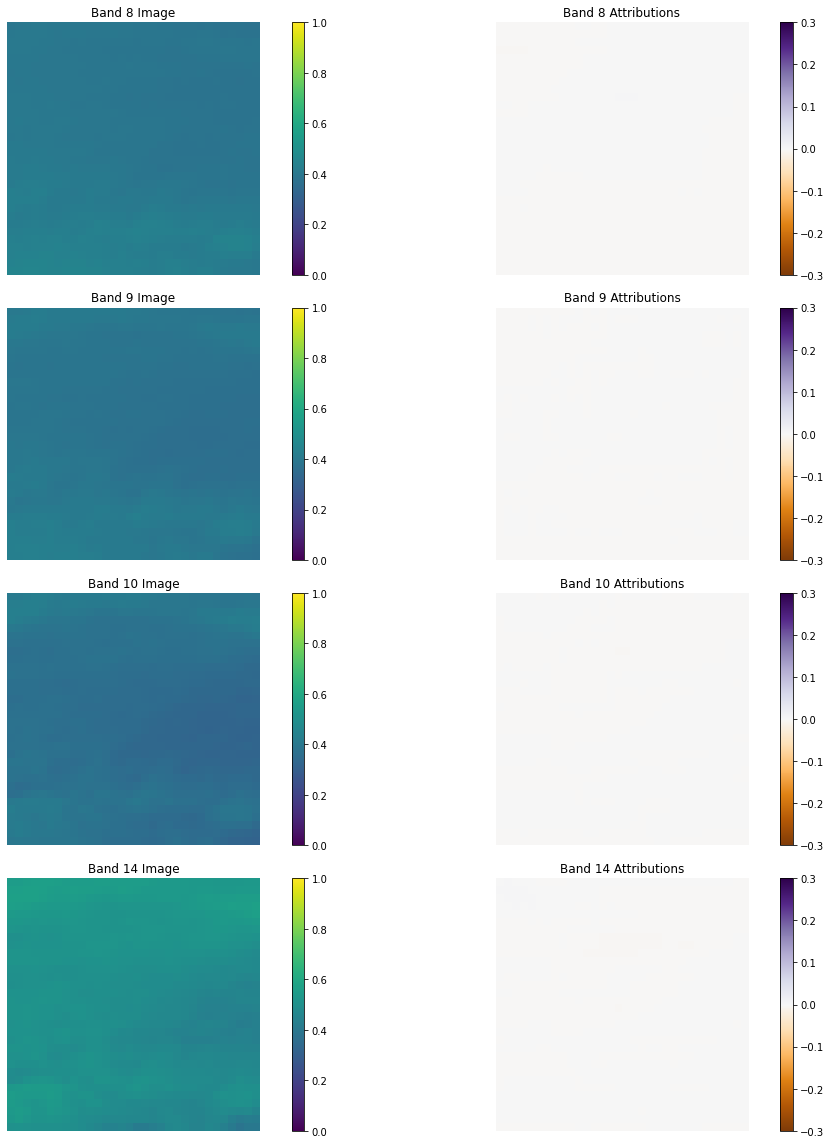

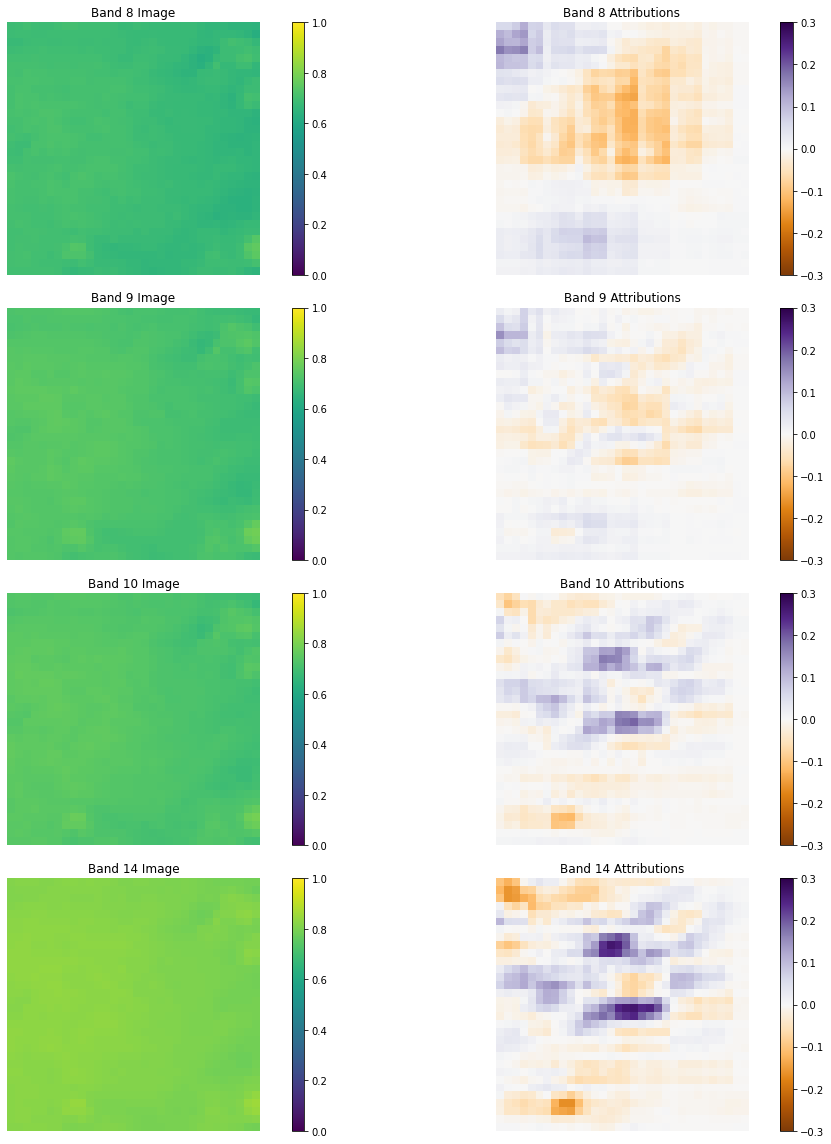

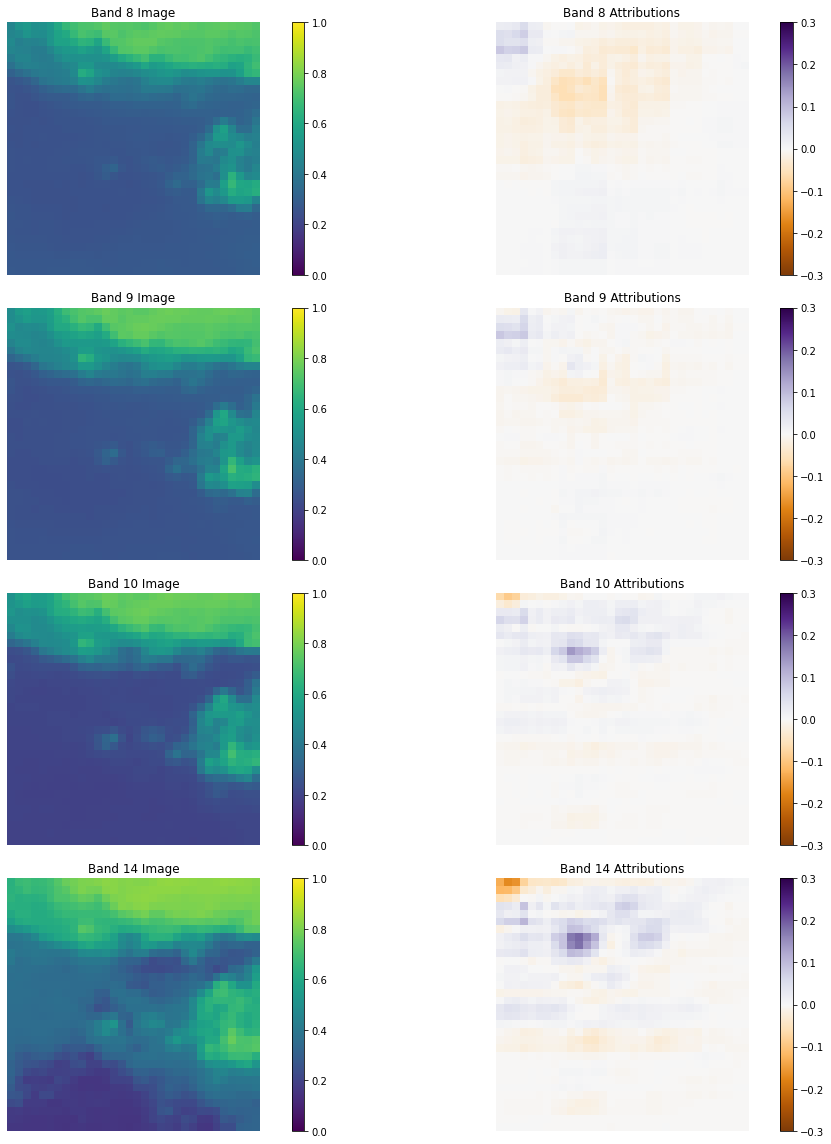

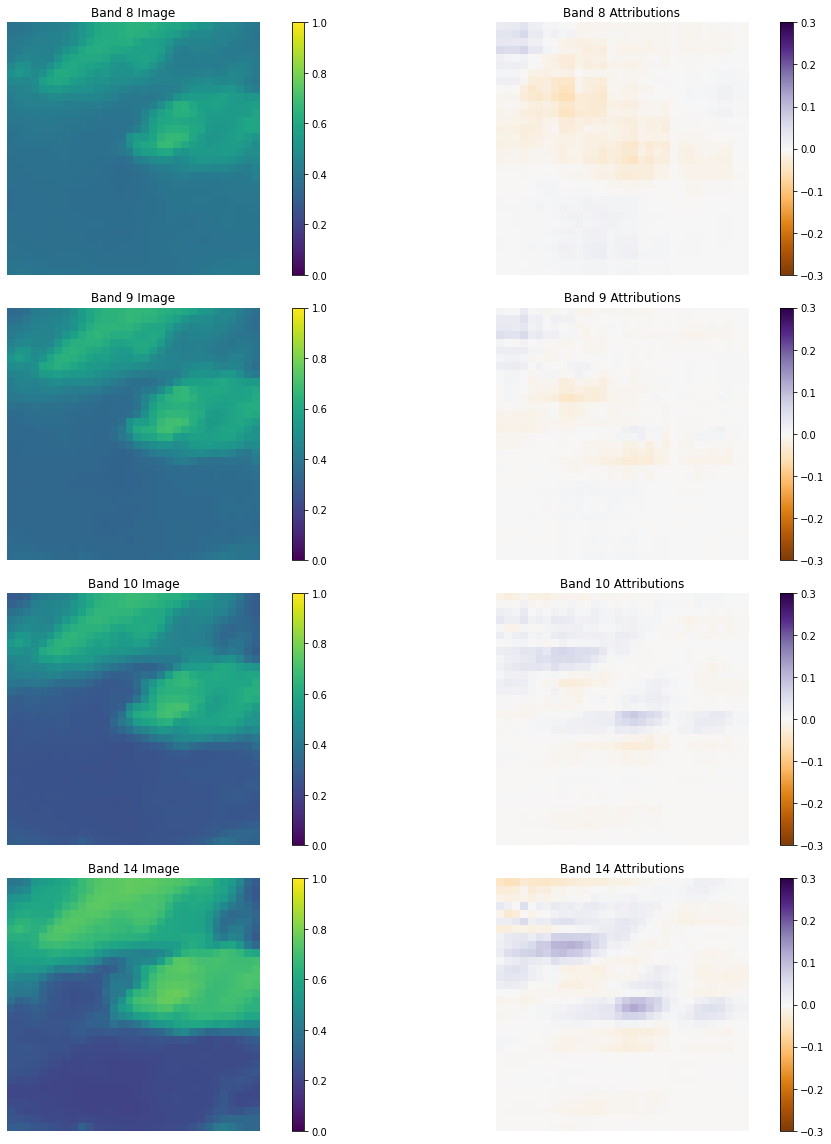

In [97]:
_ = attributions_visualization(attributions_mult[27], samp_all[27], curr_class=" 0 Lightning Count")
_ = attributions_visualization(attributions_mult[48], samp_all[48],  curr_class=" 1-9 Lightning Count")
_ = attributions_visualization(attributions_mult[77], samp_all[77],  curr_class=" 10-99 Lightning Count")
_ = attributions_visualization(attributions_mult[110], samp_all[110],  curr_class=" 100+ Lightning Count")

In [109]:
samp_all[k][:, :, 1:2].shape

(32, 32, 1)

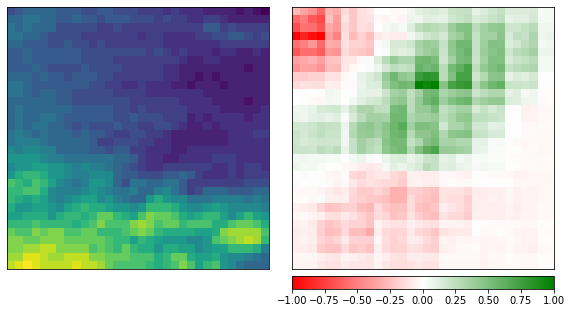

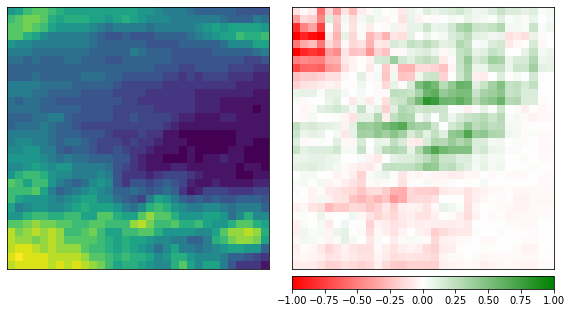

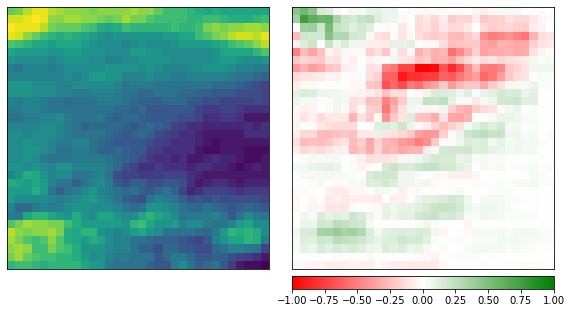

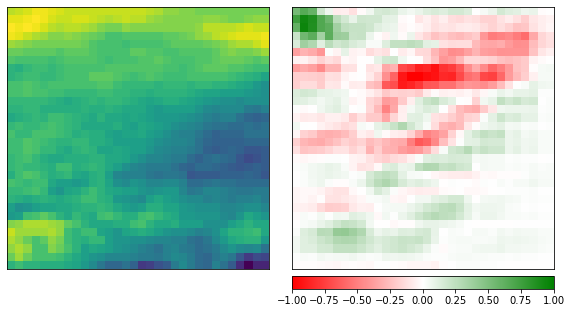

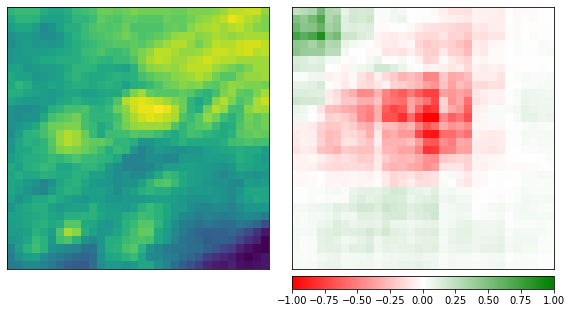

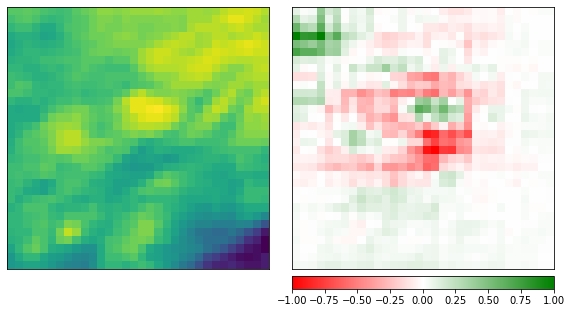

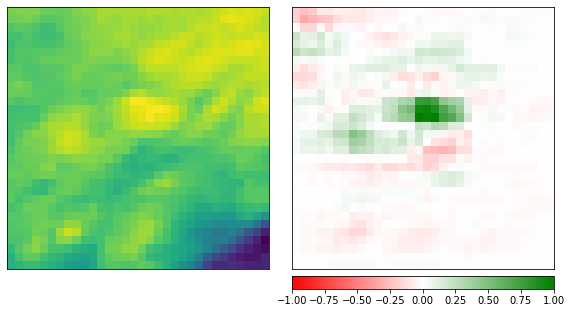

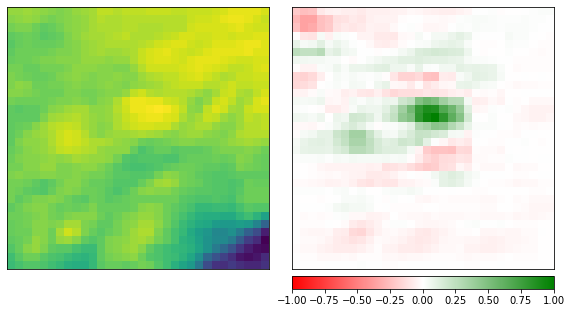

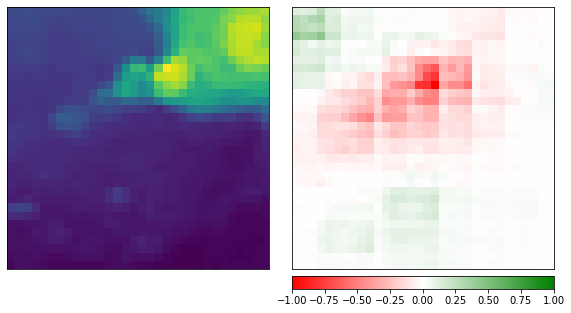

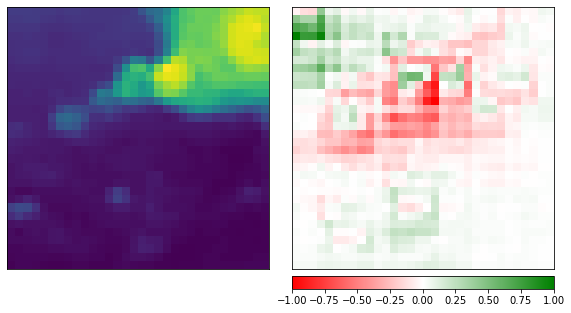

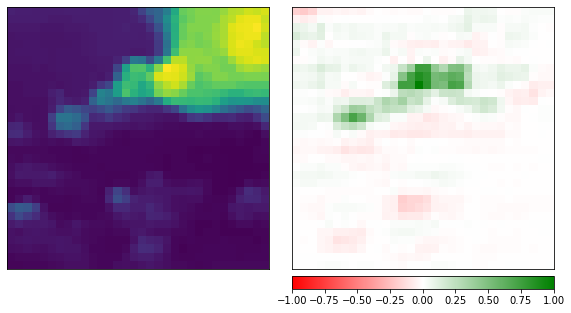

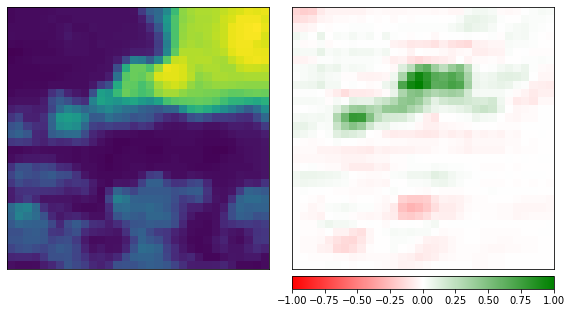

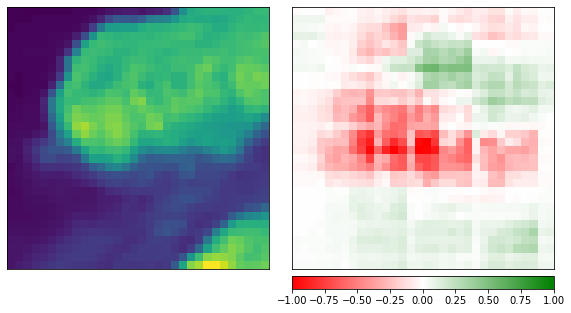

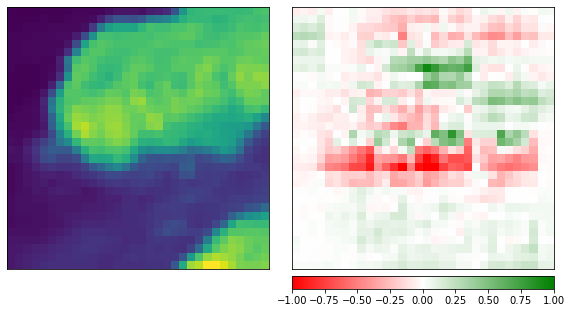

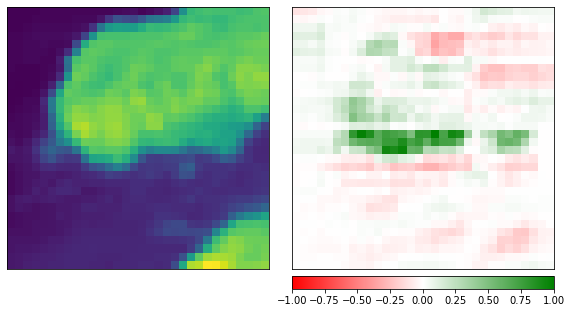

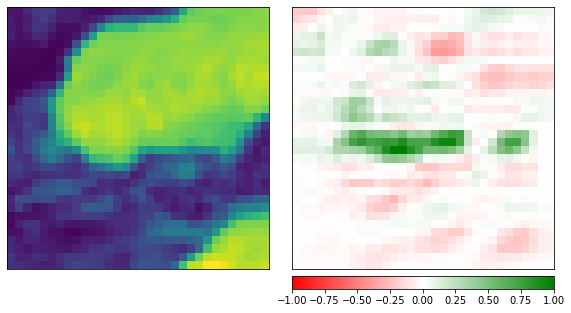

In [98]:
for k in ([27, 44, 81, 103]):
    for i in range(4):
        _ = viz.visualize_image_attr_multiple(attributions_mult[k,:,:, i:i+1],
                                          samp_all[k,:, :, i:i+1],
                                          ["original_image", "heat_map"],
                                          ["all", "all"],
                                          show_colorbar=True,
                                            outlier_perc=1)


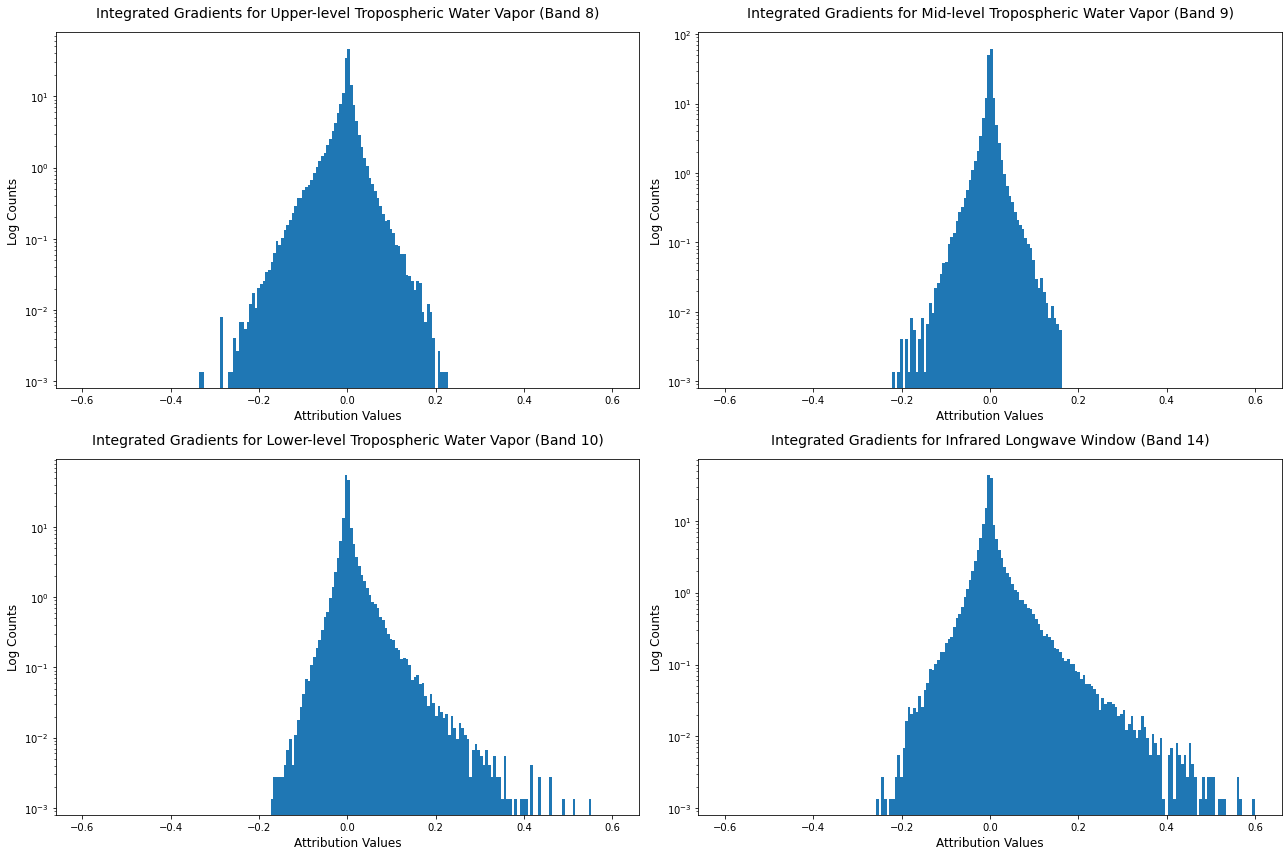

In [64]:
#Attributions Plotting for the four bands
attributions_channels = attributions_mult.transpose(3, 1, 2, 0)
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = False)
attributions_channels.shape
l =["Upper-level Tropospheric Water Vapor (Band 8)", "Mid-level Tropospheric Water Vapor (Band 9)",
    "Lower-level Tropospheric Water Vapor (Band 10)", "Infrared Longwave Window (Band 14)"]
it = 0
histogram_store = []
for i in range(2):
    for j in range (2):
        attributions_channels[it].flatten()
        axs[i, j].set_title("Integrated Gradients for " + l[it] , fontsize=14, pad=15 )
        axs[i,j].set_xlabel("Attribution Values", fontsize = 12)
        axs[i,j].set_ylabel("Log Counts", fontsize = 12)
        _ =axs[i, j].hist(attributions_channels[it].flatten(), bins = 200, density = True, range = (-0.6, 0.6), log=True)
        histogram_store.append(_[0])
        it += 1

plt.tight_layout()

plt.savefig("atributions_channels")
plt.show()
    

### Repeat of previous analysis with the Baseline set to the average bin 0 image

In [64]:
integrated_gradients = IntegratedGradients(model)
attributionsBase_mult = []

for input1 in all_images:
    input1 = torch.tensor(input1)
    input1 = input1.unsqueeze(0).cuda()
    prediction_score, pred_label_idx = torch.topk(total_outputs[idx], 1)
    attributionsBase_ig = integrated_gradients.attribute(input1, target = pred_label_idx, n_steps = 250, baselines= base_zero.unsqueeze(0).cuda() )
    attributionsBase_mult.append(np.transpose(attributionsBase_ig.squeeze().cpu().detach().numpy(), (1,2,0)))
attributionsBase_mult = np.array(attributionsBase_mult)

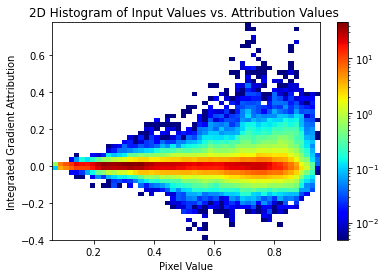

In [65]:
plt.xlabel("Pixel Value")
plt.ylabel("Integrated Gradient Attribution")
plt.title("2D Histogram of Input Values vs. Attribution Values ")
hi_ = plt.hist2d(samp_all.flatten(), attributionsBase_mult.flatten(), density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()


In [87]:
attributionsBase_mult.shape

(120, 32, 32, 4)

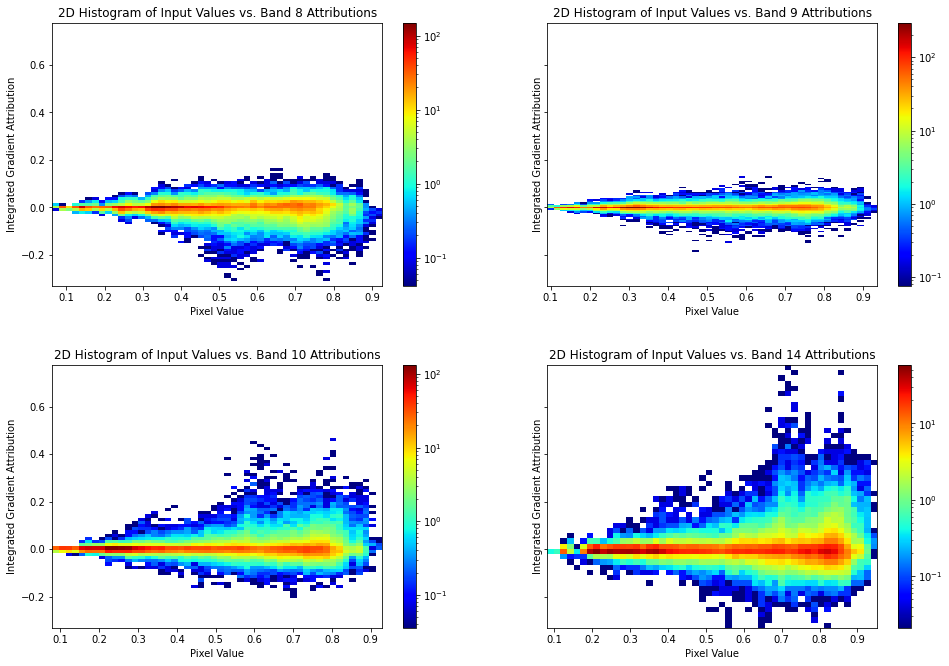

In [66]:
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
l =["Band 8 Attributions", "Band 9 Attributions",
    "Band 10 Attributions", "Band 14 Attributions"]

it = 0
for i in range(2):
    for j in range (2):
        axs[i, j].set_title("2D Histogram of Input Values vs. " + l[it] )
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attribution")
        hi_ = axs[i,j].hist2d(samp_all[:, :, :, it].flatten(), attributionsBase_mult[:, :, :, it].flatten(), density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)
plt.savefig("bandwise2d.png")
plt.show()

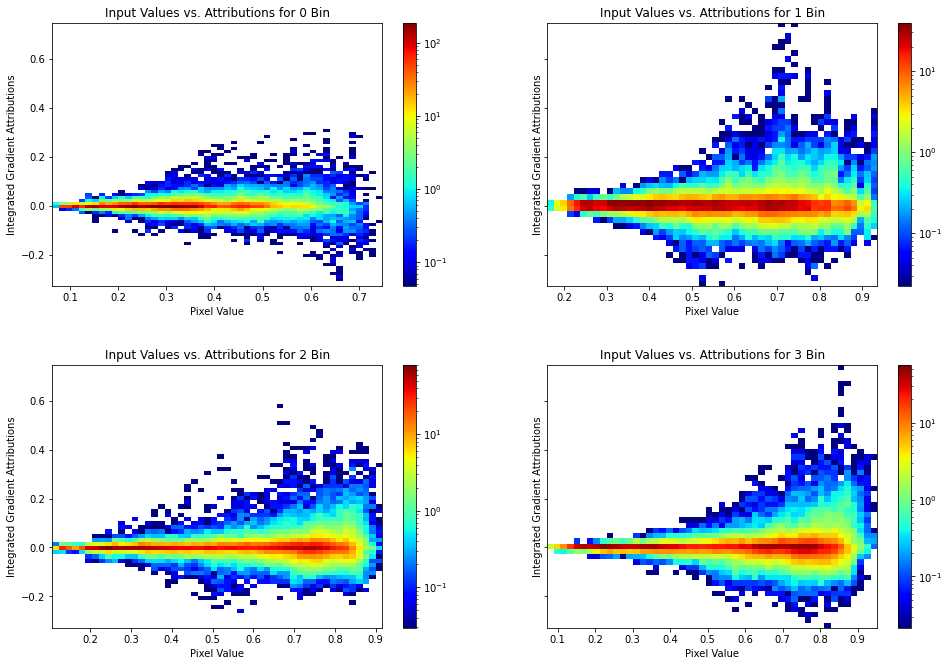

In [67]:
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
classifications = ['0 Bin', '1 Bin', '2 Bin', '3 Bin']

it = 0
for i in range(2):
    for j in range (2):
        axs[i, j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attributions")
        hi_ = axs[i,j].hist2d(samp_all[random_size*(it):random_size+random_size*(it), :, :, :].flatten(), 
                              attributionsBase_mult[random_size *(it):random_size+random_size*(it), :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

plt.show()

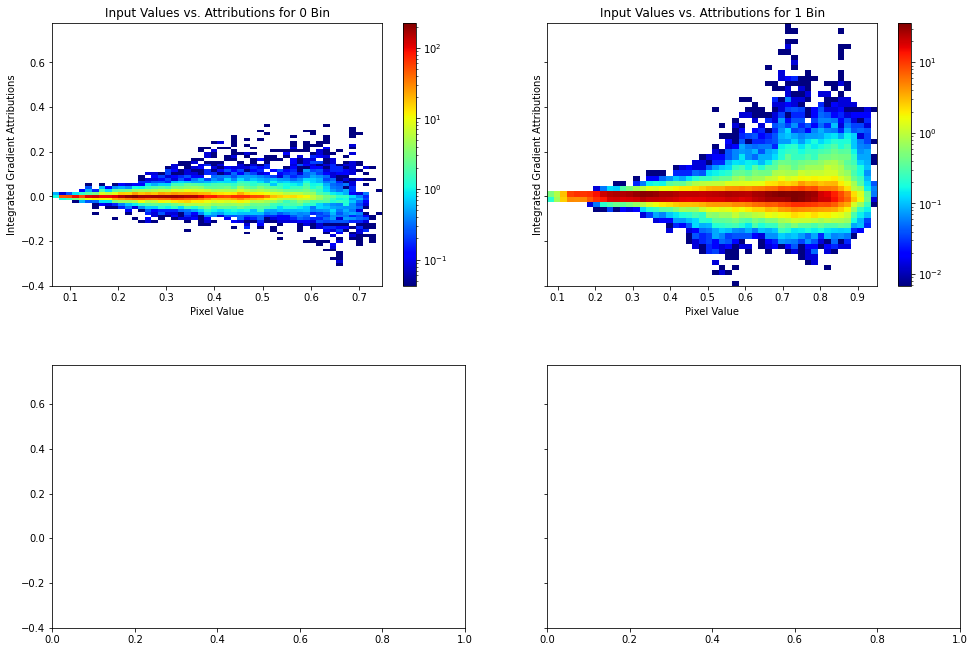

In [68]:
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
classifications = ['0 Bin', '1 Bin', '2 Bin', '3 Bin']

it = 0
for i in range(2):
    for j in range (2):
        if(it == len(predicted_dict)):
           break
        axs[i, j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attributions")
        hi_ = axs[i,j].hist2d(samp_all[predicted_dict[it], :, :, :].flatten(), 
                              attributionsBase_mult[predicted_dict[it], :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1
    else:
        continue
    break
    

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

plt.show()

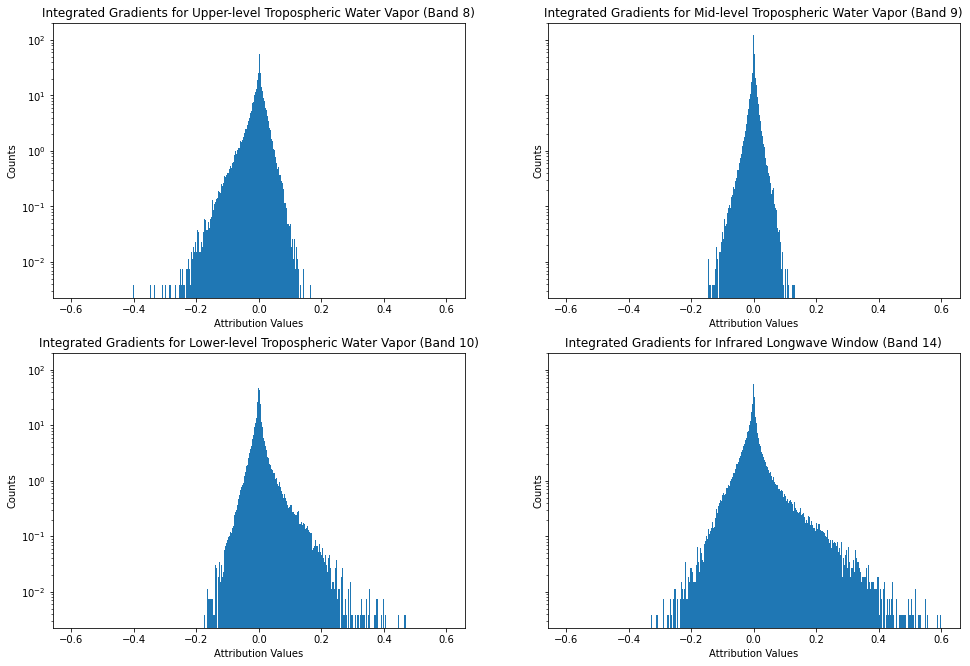

In [69]:
attributions_channels = attributionsBase_mult.transpose(3, 1, 2, 0)
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
attributions_channels.shape
l =["Upper-level Tropospheric Water Vapor (Band 8)", "Mid-level Tropospheric Water Vapor (Band 9)",
    "Lower-level Tropospheric Water Vapor (Band 10)", "Infrared Longwave Window (Band 14)"]
it = 0
histogram_store = []
for i in range(2):
    for j in range (2):
        attributions_channels[it].flatten()
        axs[i, j].set_title("Integrated Gradients for " + l[it] )
        axs[i,j].set_xlabel("Attribution Values")
        axs[i,j].set_ylabel("Counts")
        _ =axs[i, j].hist(attributions_channels[it].flatten(), bins = 557, density = True, log=True, range=(-0.6, 0.6))
        histogram_store.append(_[0])
        it += 1

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)
plt.show()